## Problem Set 6 (February 26, 2017)
## MACS 30100
## Dr. Rick Evans
## Kevin Sun

### 1) Decision Trees

In [45]:
# import relevant libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

In [46]:
# import data
biden_GOAT_vp = pd.read_csv('biden.csv')
biden_GOAT_vp.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


### 1a)

In [47]:
# set response and predictor variables
y = biden_GOAT_vp['biden'].values
X = biden_GOAT_vp[['female', 'age', 'educ', 'dem', 'rep']].values

In [48]:
# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)
biden_2020_tree = DecisionTreeRegressor(max_depth=3)

biden_2020_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

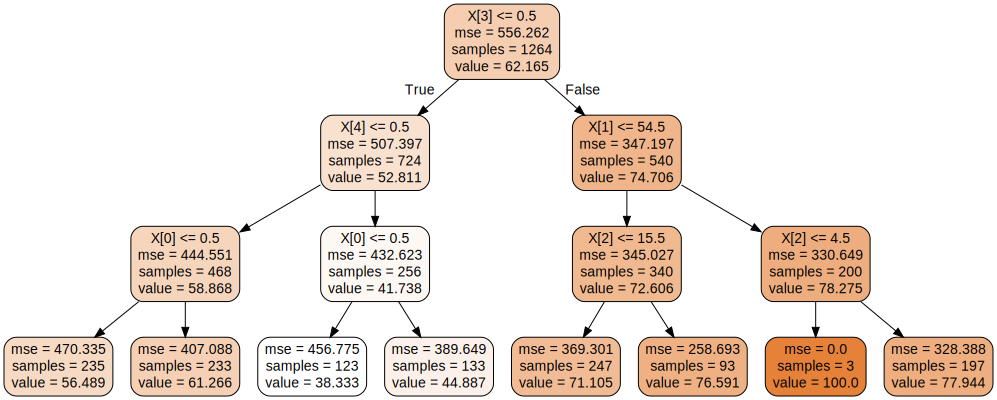

In [49]:
# map the tree visualization
biden_2020_tree_viz = export_graphviz(biden_2020_tree, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_2020_tree_viz)
graph.render('biden_2020_tree')
graph

In [50]:
y_pred = biden_2020_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 394.761999922


#### Interpretation

The main split is on our X3 variable (dem - whether or not individual identifies as a Democrat). As we would expect, individuals who do identify as Democrats have much warmer feelings towards Joe Biden (74.706) compared to non-Democrat individuals' feelings (52.811). 

Within identfied Democrats, the tree further divides on our X1 variable with those below 54.5 years of age and those above. Those above 54.5 years of age have slightly warmer feelings than those below (78.275 vs. 72.606). Within each of these age groups, we further divide by on our X2 variable (educ - num. of years of education). For younger individuals below 54.5 years-old, if they have greater than 15.5 years of education, they have slightly warmer feelings towards Biden than those will less education. For older individuals over 54.5 years-old, those with less than 4.5 years of education have the highest warmth of feelings towards Biden at 100, but there is only a sample of 3. 

Within non-Democrat individuals, the tree first divides on our X4 variable (rep - whether the individual identifies as Republican or not). Republican-identified individuals have much colder feelings towards Biden at 41.738 compared to Independent or third party identified individuals at 58.868. Within Republican identified individuals, women view Biden more favorably than men. Within non-Republican and non-Democrat individuals women also have slightly more favorable views of Biden than men. 

### 1b) Pruning the tree

In [51]:
nobs = len(X_train)
nobs

1264

In [62]:
# for each of the max_depth run a k-folds (nested for loop)
# max graph with SE on x axis and max_depth on y axis
k = 5
kf = KFold(n_splits=k, random_state=25, shuffle=True)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(X):
    print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 501.356353591
k index= 1
MSE for test set 1  is 565.607734807
k index= 2
MSE for test set 2  is 463.736842105
k index= 3
MSE for test set 3  is 520.925207756
k index= 4
MSE for test set 4  is 446.606648199
test estimate MSE k-fold= 499.646557292 test estimate MSE standard err= 42.2121331122


In [33]:
# What are the parameters used in the instructions? 
biden_2024_tree = DecisionTreeRegressor(max_depth=3, min_impurity_decrease=0.0)
biden_2024_tree.fit(X_train, y_train)

# map the tree visualization
biden_2024_tree_viz = export_graphviz(biden_2024_tree, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_2024_tree_viz)
graph.render('biden_2020_tree')
#graph

'biden_2020_tree.pdf'

In [30]:
y_pred = biden_2024_tree.predict(X_test)
MSE1b = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1b)

MSE= 400.113290357


### 1c) Bagging

In [54]:
biden_bags_presidency_tree = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=25)
biden_bags_presidency_tree.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=25, verbose=0, warm_start=False)

In [56]:
# calculate MSE
biden_bags_presidency_tree.score(X, y)
y_pred_bag = biden_bags_presidency_tree.oob_prediction_
MSE2 = mean_squared_error(y, y_pred_bag)
print('MSE=', MSE2)

MSE= 405.227410433


/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/kevinsun/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Min. MSE= 403.326854933 , Min. B= 148


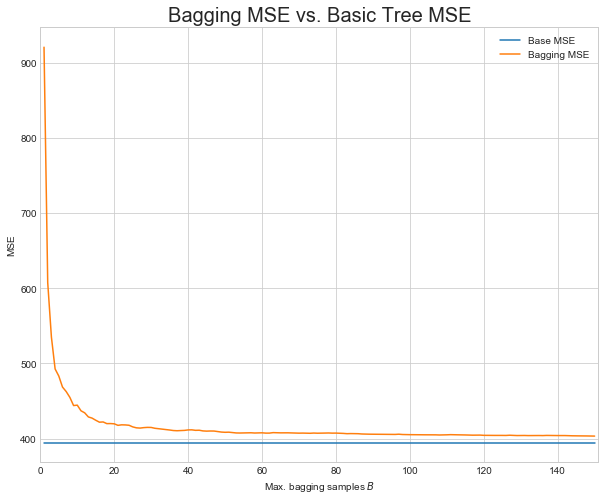

In [59]:
# determine optimal number of samples
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

MSE_base = MSE1
max_samples = 150
MSE_vec = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    biden_tree_loop = BaggingRegressor(DecisionTreeRegressor(), n_estimators=ind,
                                 max_samples=100, bootstrap=True, oob_score=True,
                                 random_state=25)
    biden_tree_loop.fit(X, y)
    y_pred_loop = biden_tree_loop.oob_prediction_
    MSE_vec[ind - 1] = mean_squared_error(y, y_pred_loop)

fig, ax = plt.subplots()
plt.plot(np.arange(1, max_samples + 1), MSE_base * np.ones(max_samples),
         label='Base MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec, label='Bagging MSE')
# for the minor ticks, use no labels; default NullFormatter
plt.title('Bagging MSE vs. Basic Tree MSE', fontsize=20)
plt.xlabel(r'Max. bagging samples $B$')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.legend(loc='best')

print('Min. MSE=', MSE_vec.min(), ', Min. B=', np.argwhere(MSE_vec == MSE_vec.min())[0, 0] - 1)

### 1d) Random Forest

In [61]:
B = 100
m = 1
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

MSE= 535.303205925


In [27]:
# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

Feature Ranking:

1 .  female :  0.478975783969
2 .  age :  0.253838596315
3 .  educ :  0.162716068913
4 .  dem :  0.0870908655179
5 .  rep :  0.0173786852847


In [43]:
B = 100
m = 2
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

MSE= 535.676877523
Feature Ranking:

1 .  female :  0.513447807068
2 .  age :  0.184413807351
3 .  educ :  0.151779735233
4 .  dem :  0.129449265728
5 .  rep :  0.0209093846201


In [44]:
B = 100
m = 3
biden_random_forest = RandomForestRegressor(n_estimators=B, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_random_forest.fit(X, y)

biden_random_forest.score(X, y)
y_pred_rf = biden_random_forest.oob_prediction_
MSE4 = mean_squared_error(y, y_pred_rf)
print('MSE=', MSE4)

# calculate variable importances
importances = biden_random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_random_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# print the rankings of features
print("Feature Ranking:")
print()
features = ['female', 'age', 'educ', 'dem', 'rep']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

MSE= 534.489301047
Feature Ranking:

1 .  female :  0.486208492733
2 .  age :  0.203115126926
3 .  educ :  0.170068692665
4 .  dem :  0.112758675093
5 .  rep :  0.0278490125828
